# 5.4 Visualizing what convnets learn

* Visualizing intermediate convnet outputs (intermediate activations)—Useful for
understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* Visualizing heatmaps of class activation in an image—Useful for understanding
which parts of an image were identified

### 5.4.1 Visualizing intermediate activations

In [2]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

#### Listing 5.25 Preprocessing a single image

In [3]:
img_path = './dog_cat/test1/3.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# <1> Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


## Listing 5.26 Displaying the test picture

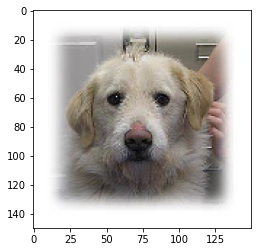

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()


##### Listing 5.27 Instantiating a model from an input tensor and a list of output tensors

In [5]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

#### Listing 5.28 Running the model in predict mode

In [6]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


#### Listing 5.29 Visualizing the fourth channel

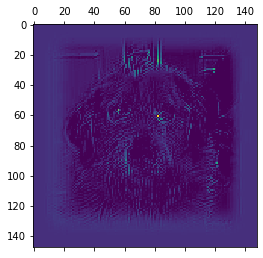

In [7]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


#### Listing 5.30 Visualizing the seventh channel

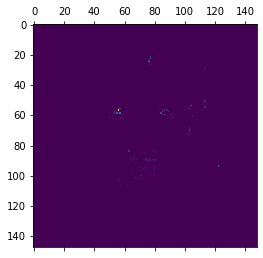

In [8]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

#### Listing 5.31 Visualizing every channel in every intermediate activation

<ipython-input-9-a07f8362c253>:15: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


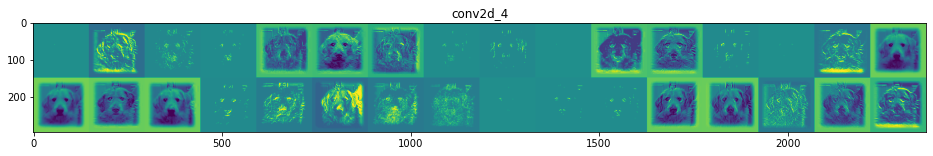

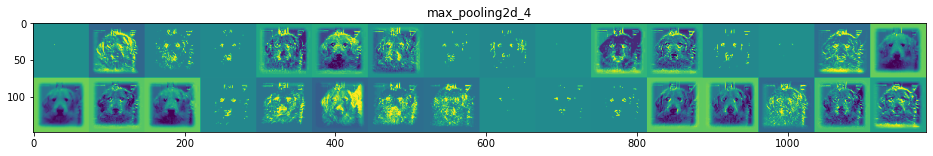

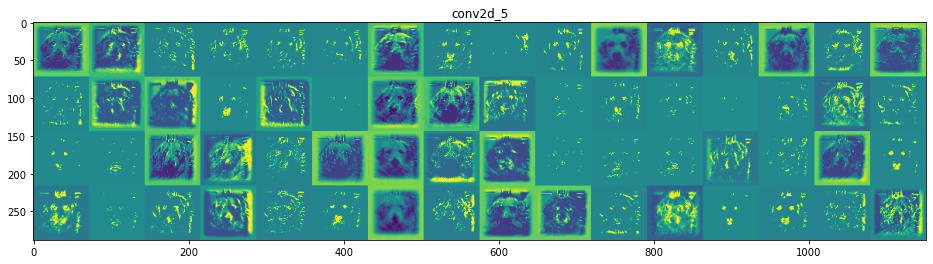

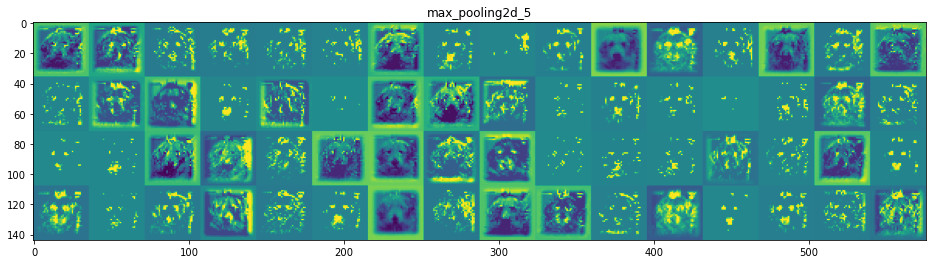

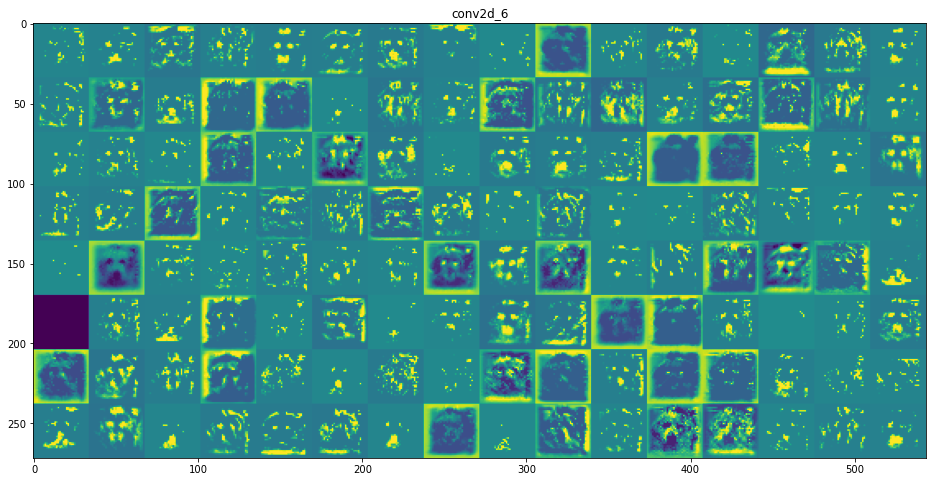

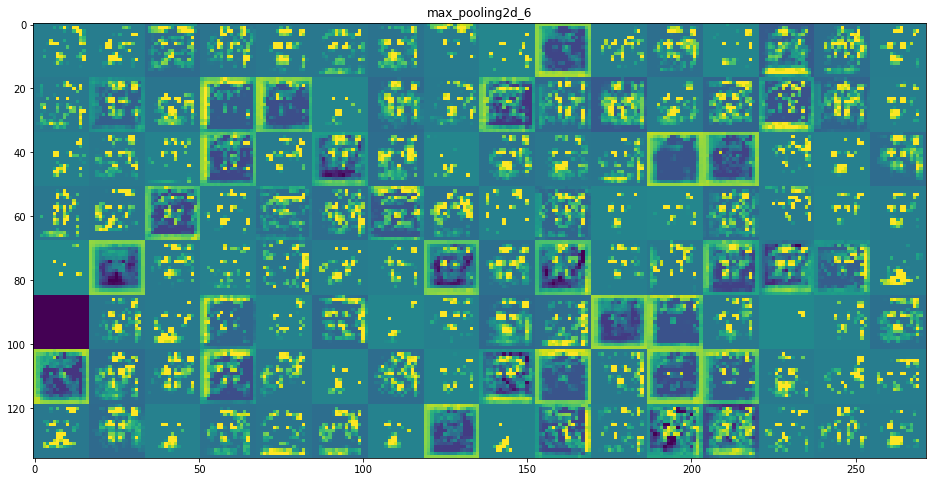

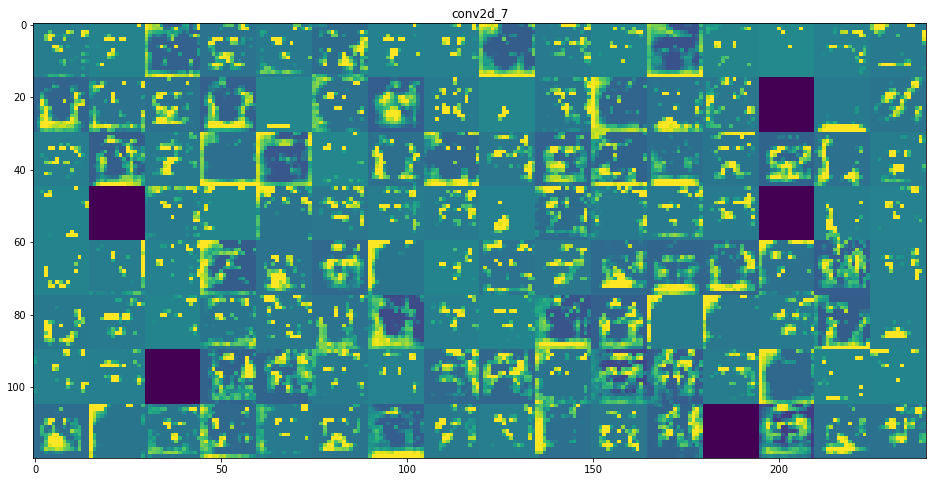

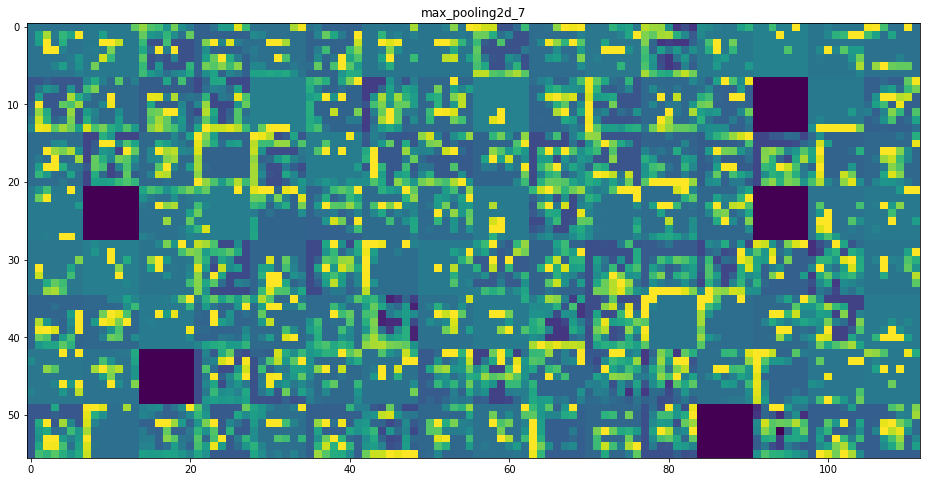

In [9]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


# 5.4.2 Visualizing convnet filters

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
model = VGG16(weights='imagenet',include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

#### Listing 5.33 Obtaining the gradient of the loss with regard to the input

In [11]:
grads = K.GradientTape(loss, model.input)[0]
#K.gradients()

AttributeError: module 'tensorflow.keras.backend' has no attribute 'GradientTape'

In [12]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10508481825851921459,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 616133600832775689
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15549934352411511953
 physical_device_desc: "device: XLA_GPU device"]

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

    
# Run on the GPU
c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
